# Model Interpretation

This notebook is used for learning how the models work and which features are the most important for the predictions.

## Imports and Global Settings

In [1]:
# Basic Data Science
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Advanced EDA
from dataprep.eda import plot, plot_correlation, plot_missing
# Model Setup
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Model Results and Metrics
from sklearn.metrics import (plot_roc_curve, plot_precision_recall_curve,
                             confusion_matrix, classification_report)
# Model Interpretation Libraries
import eli5
import shap
shap.initjs()
# Global pandas and matplotlib options
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

NumExpr defaulting to 4 threads.


## Helper Functions

In [2]:
def quick_model_metrics(fitted_model, X_train, y_train, X_test, y_test):
    """
    Model accuracy vs baseline (majority class - Not Fraud)
    for training and testing datasets.

    Args:
        fitted_model (object)
        X_train (dataframe)
        y_train (dataframe)
        X_test (series)
        y_test (series)
    """
    train_baseline = y_train[y_train == "Not Fraud"].size / y_train.size
    test_baseline = y_test[y_test == "Not Fraud"].size / y_test.size
    train_accuracy = fitted_model.score(X_train, y_train)
    test_accuracy = fitted_model.score(X_test, y_test)
    print(f"Train Baseline: {train_baseline:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Baseline: {test_baseline:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

In [3]:
def save_fitted_model(model, filename):
    """
    Save fitted model to models folder in pickle format.

    Args:
        model (object): Fitted model
        filename (string): Model name
    """
    filepath = f"../models/{filename}.pkl"
    with open(filepath, "wb") as file:
        pkl.dump(model, file)
    print("Model saved successfully.")

In [4]:
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
# https://github.com/DTrimarchi10/confusion_matrix

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Load Data

In [5]:
filename = "model_data_v2"
data = pd.read_json(f'../data/{filename}.json', orient='records', lines=True)

df = data.copy()

## Model Setup

In [6]:
all_possible_features = [
        "approx_payout_date", "body_length", "channels", "country",
        "currency", "delivery_method", "description", "email_domain",
        "event_created", "event_end", "event_published", "event_start",
        "fb_published", "gts", "has_analytics", "has_header", "has_logo",
        "listed", "name", "name_length", "num_order", "num_payouts",
        "object_id", "org_desc", "org_facebook", "org_name", "org_twitter",
        "payee_name", "payout_type", "sale_duration", "sale_duration2",
        "show_map", "user_age", "user_created", "user_type", "venue_address",
        "venue_country", "venue_latitude", "venue_longitude", "venue_name",
        "venue_state", "num_previous_payouts", "previous_payouts_total",
        "num_ticket_types", "num_tickets_available", "total_ticket_value",
        "avg_ticket_cost", "known_payee_name", "known_venue_name",
        "known_payout_type", "total_empty_values", "name_proba",
        "description_proba", "org_name_proba", "org_desc_proba"
        ]

features_to_test = [
        "body_length", "channels", "delivery_method", "fb_published",
        "gts", "has_analytics", "has_header", "has_logo", "listed",
        "name_length", "num_order", "num_payouts", "org_facebook",
        "org_twitter", "user_type", "sale_duration", "sale_duration2",
        "show_map", "user_age", "venue_latitude", "venue_longitude",
        "num_previous_payouts", "previous_payouts_total",
        "num_ticket_types", "num_tickets_available", "total_ticket_value",
        "avg_ticket_cost", "known_payee_name", "known_venue_name",
        "known_payout_type", "total_empty_values", "name_proba",
        "description_proba", "org_name_proba", "org_desc_proba"
        ]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
        df[features_to_test],
        df['is_fraud'],
        test_size=0.25,
        random_state=10,
    )

## Scale Data

In [8]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Model Parameters

In [9]:
models = {"log_reg": LogisticRegression, "forest": RandomForestClassifier}

In [10]:
log_reg_best_params = dict(
    penalty="l2",
    C=1,
    class_weight='balanced',
    random_state=7,
    solver="newton-cg",
    max_iter=10000,
    tol=0.0001,
    l1_ratio=None,
)

forest_best_params = dict()

In [11]:
model = models["log_reg"]
model_params = log_reg_best_params

In [12]:
clf = model(**model_params)

In [13]:
clf.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=10000, random_state=7,
                   solver='newton-cg')

In [14]:
predictions = clf.predict(X_test)

## Model Results

In [15]:
quick_model_metrics(
        clf,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
    )

Train Baseline: 0.9102
Train Accuracy: 0.9998
Test Baseline: 0.9066
Test Accuracy: 0.9536


In [16]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       Fraud       0.92      0.55      0.69       268
   Not Fraud       0.96      1.00      0.97      2600

    accuracy                           0.95      2868
   macro avg       0.94      0.77      0.83      2868
weighted avg       0.95      0.95      0.95      2868



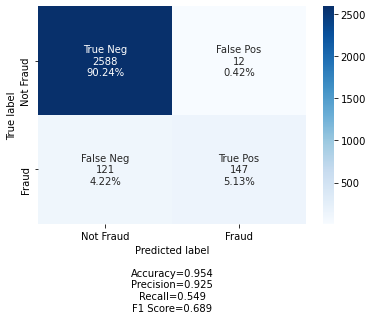

In [17]:
cf_matrix = confusion_matrix(y_test, predictions, labels=['Not Fraud', 'Fraud'])
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Not Fraud', 'Fraud']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

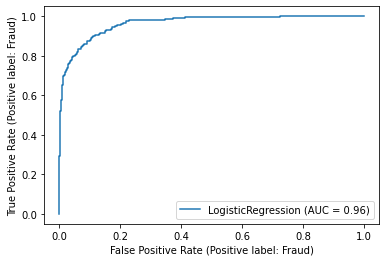

In [18]:
plot_roc_curve(clf, X_test, y_test, pos_label="Fraud")

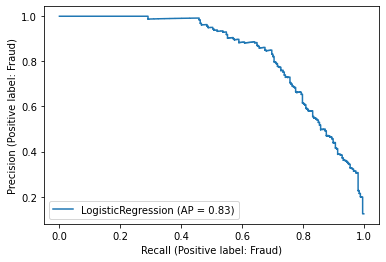

In [19]:
plot_precision_recall_curve(clf, X_test, y_test, pos_label="Fraud")

## Save Model

In [20]:
# model_name_to_save = "_test_1"
# save_fitted_model(clf, model_name_to_save)

## Load Model

In [21]:
# model_name_to_load = "_test_"

# clf = None
# with open(f"../models/{model_name_to_load}.pkl", "rb") as f:
#     clf = pkl.load(f)

## Model Interpretation

### eli5

In [22]:
eli5.show_weights(clf, feature_names = features_to_test, 
                  top=None, show=['targets', 'method', 'description',
                                  'decision_tree', 'feature_importances'])

Weight?,Feature
+10.081,<BIAS>
+0.869,org_facebook
+0.822,user_age
+0.598,user_type
+0.584,org_twitter
+0.477,known_venue_name
+0.460,sale_duration2
+0.375,body_length
+0.363,delivery_method
+0.256,known_payee_name


### SHAP

In [23]:
explainer = shap.Explainer(clf, X_train, feature_names=features_to_test)
shap_values = explainer(X_test)

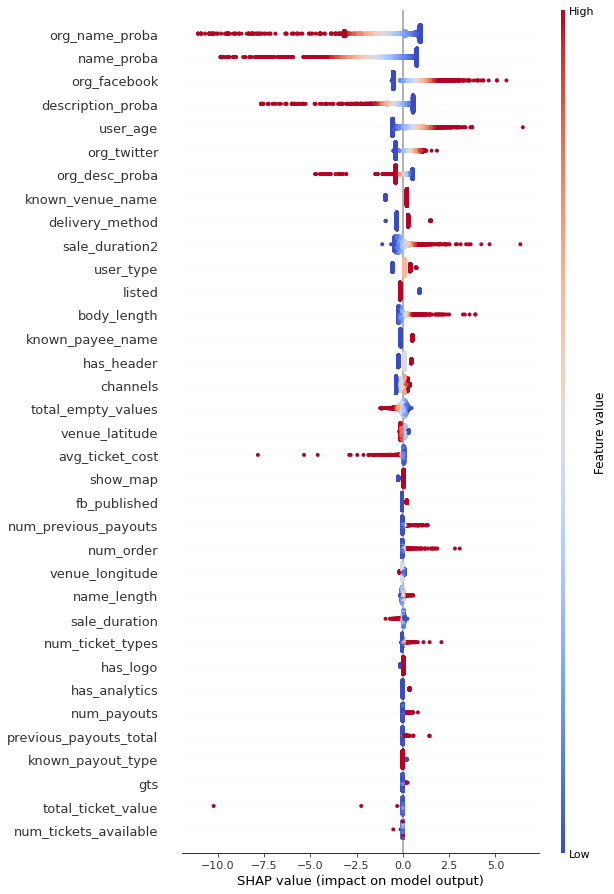

In [24]:
shap.plots.beeswarm(shap_values, max_display=None, color=plt.get_cmap("coolwarm"))

Fraud


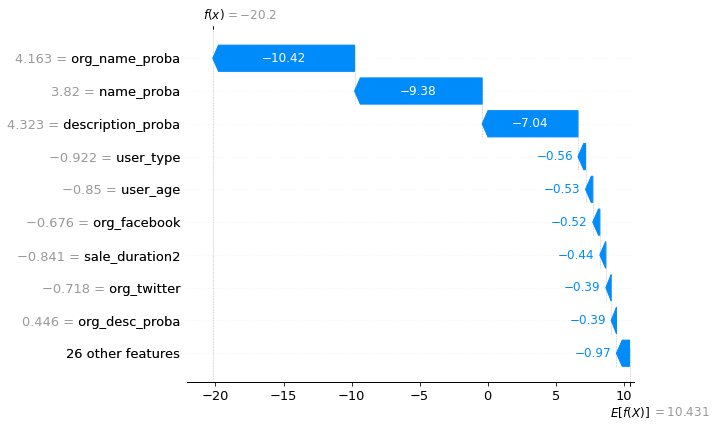

In [26]:
index_num = 6

print(f'{y_test.iloc[index_num]}')
shap.plots.waterfall(shap_values[index_num])